# Learning a representation of handwritten digits

This notebook explores a classic convolutional neural network architecture (LeNet-5) for categorizing handwritten digits.  We visualize the learned representation and explore if we can use the network to generate new images of digits.

*You will most likely want to use the GPU runtime for this notebook -- click "Change runtime type" under the "Runtime" menu in Google Colab.*

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.ndimage import rotate

## Data loading and preprocessing

First we load the MNIST dataset using the Keras library and do some simple preprocessing.

In [2]:
# x contains images, y contains integer labels (0-9)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# convert to "one hot" encoding
y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)

11493376/11490434 [==============================] - 2s 0us/step


For preprocessing, we add an extra dimension so that the images are 4-dimensional as required by Keras, and convert then to floating point in [-1 1] range.

In [3]:
x_train = np.expand_dims(x_train,axis=-1)
x_test = np.expand_dims(x_test,axis=-1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = x_train*2.-1.
x_test = x_test*2.-1.

We show a 5x5 grid of images from the dataset.  Always remember to look at your data!

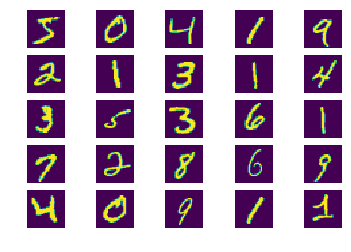

In [4]:
n = 0
for i in range(5):
  for j in range(5):
    plt.subplot(5,5,n+1)
    plt.imshow(np.squeeze(x_train[n]))
    plt.axis('off')
    n = n + 1

## Convolutional Neural Network Model

Convolutional neural network are often appropriate for image processing tasks.  The early layers of the network consist of small convolutional filters which act like local feature detectors; the later layers of the network aggregate the local feature responses into a global prediction.

A convolutional layer is parameterized by a filter matrix $W$ and a bias vector $b$:

$$\mathbf{z} =\sigma(\mathbf{W} * \mathbf{x} + \mathbf{b})$$

where $*$ indicates the convolution operation.  The filter "slides" over the input image $\mathbf{x}$ and performs a dot product over a local window at each pixel in the image.

Here we build a [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) model which uses 5x5 convolutional filters and max pooling to downsample and aggregate filter responses.

We add an additional 2-dimensional hidden layer before the final linear classifier to aid in visualizing the representation learned by the network.

The model should have the following architecture:
* 2D convolution with 50 5x5 filters, 'valid' padding, ReLU activation
* 2D max pooling with 2x2 window, stride of 2
* 2D convolution with 20 5x5 filters, 'valid' padding, ReLU activation
* 2D max pooling with 2x2 window, stride of 2
* Flatten
* Fully connected layer with 200 units, ReLU activation
* Fully connected layer with 2 units, linear activation ("embedding" layer for visualization)
* Fully connected layer with 10 units, softmax activation (linear classifer)

Compile the model to use the SGD optimizer with learning rate of 0.01.  I trained for 20 epochs with a batch size of 100.




In [5]:
inputs = Input(shape=(28,28,1))
conv1 = Conv2D(50,5,padding='valid', activation='relu')(inputs)
pool1 = MaxPooling2D(2,2)(conv1)
conv2 = Conv2D(20,5,padding='valid', activation='relu')(pool1)
pool2 = MaxPooling2D(2,2)(conv2)
flattened = Flatten()(pool2)
dense1 = Dense(200, activation='relu')(flattened)

embedding = Dense(2, activation=None)(dense1)
logits = Dense(10, activation='softmax')(embedding)
model = Model(inputs=inputs, outputs=logits)

print(model.summary())

embedding_model = Model(inputs=inputs, outputs=embedding)

model.compile(optimizer=SGD(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=100, epochs=20, validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 50)        1300      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 20)          25020     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               64200     
__________

## Exercises

1. Show (as images) the filter matrices learned in the first layer of the network.  What do they look like?  What is the network looking for in the input images?
* Visualize the embedding learned by the network.  What shape does the embedding have?  Why?
* Rotate digits (scipy.ndimage.rotate) and see what happens to their class probabilities.  We would assume that an upside down 6 will be classified as a 9.  But what happens in between?  What does an upside down 2 get classified as?
* How could you make a neural network that is invariant to rotation?  You don't need to implement this, just give one or two ideas for how you could do it.
* Do a similar expeirment to the rotation experiment but linearly blend betwen two digits:
$$x = (1-\alpha)x_1 + \alpha x_2, 0 \leq \alpha \leq 1$$


1. The filters have a single are of grey/black that might be looking for certain features of the numbers, such as curves and lines. For example, a filter with a curve may match the curvature of a two, three, six, eight, nine, or zero.

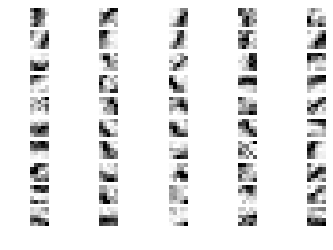

In [6]:
convLayer1 = model.layers[1]
wsAndBs = convLayer1.get_weights()
weights = np.squeeze(wsAndBs[0])
biases = wsAndBs[1]

n = 0
for i in range(10):
  for j in range(5):
    plt.subplot(10,5,n+1)
    filter = weights[:,:,n]
    plt.imshow(filter, cmap='Greys', interpolation='nearest')
    plt.axis('off')
    n = n + 1

2. The embedding shows that each digit has been clustered into specific locations on the 2D plane. The resulting shape is centered around the origin and the  clusters are separable by hyperplanes defined by a linear classifier.

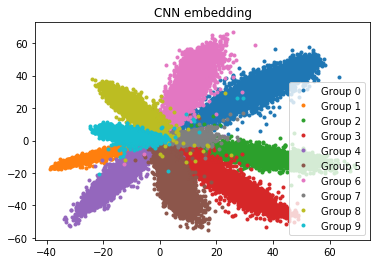

In [7]:
def plot_embedding(encoder):
  y_labels = np.argmax(y_train, axis=1)
  h = encoder.predict(x_train)
  for i in range(10):
      sel = y_labels == i
      plt.plot(h[sel,0], h[sel,1], '.', label='Group %d' % i)
  plt.title('CNN embedding')
  plt.legend()
  plt.show()
  
plot_embedding(embedding_model)

3.It is not predictable what a number gets classified as during rotations. The classification depends on how the filters line up with the image. At times, a rotated number appears like a similar number, such as in the case of the upside down 9 looking like a 6. Also, an upside down 2 looks like another 2. The probability distribution produced by the softmax function does not smoothly transition from one number to another, as it appears random.

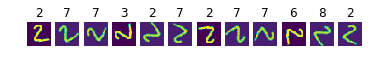

In [8]:
import scipy

def printImage(img):
  img = np.squeeze(img)
  for row in range(len(imgR)):
    for col in range(len(imgR[0])):
      print("{:.1f}".format(imgR[row][col]), end=" ")
    print()
  print("-----------------------------------------")

# Returns the predictions of each of the rotated images
def rotateAndPredict(img) -> list:
  results = []
  angle = 0
  n = 0
  for i in range(12):
    # Rotate the image 30 degrees.
    imgR = scipy.ndimage.rotate(np.squeeze(img), angle, reshape=False, cval=-1)    
    imgR = imgR[np.newaxis, :, :, np.newaxis]
    # Predict the number
    result = model.predict(imgR)
    results.append(result)
    result = np.argmax(result, axis=1)[0]
    # Graph the results
    plt.subplot(1,12,n+1).set_title(str(result))
    plt.imshow(np.squeeze(imgR))
    plt.axis('off')
    angle += 30
    n += 1
  return results

img9 = x_test[9]
img2 = x_test[1]
predictions = rotateAndPredict(img2)

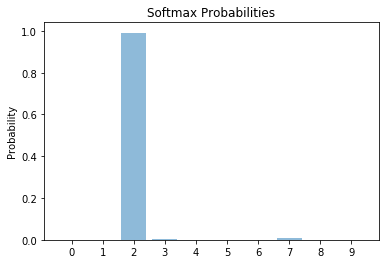

In [9]:
def graphProbabilities(prediction):
  prediction = prediction[0]    
  objects = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
  y_pos = np.arange(len(objects))
  plt.bar(y_pos, prediction, align='center', alpha=0.5)
  plt.xticks(y_pos, objects)
  plt.ylabel('Probability')
  plt.title('Softmax Probabilities')  
  plt.show()
  
graphProbabilities(predictions[6])

4. One idea to make a CNN that is invariant to rotation is to train the CNN with many images that have been rotated. We don't need to collect any more data to do this. For each image in our dataset, we can perform a transformation and save the result as part of our training and testing sets. 

5. When the first number or the second number is clearly visible with limited interference from the other number, the CNN correctly predict the appropriate label with minimum error. However, the CNN is not predictable when the two numbers are completely blended together. A smarter system should be able to pick out both numbers instead of trying to predict what the combination looks like.

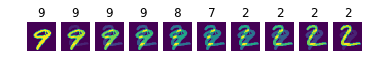

In [10]:
img9 = x_test[9]
img2 = x_test[1]

def blendAndPredict(img1, img2) -> list:
  results = []
  alpha = 0
  n = 0
  for i in range(10):
    # Combine the images
    imgBlend = np.add((1.0 - alpha)*np.squeeze(img1), alpha*np.squeeze(img2))
    imgBlend = imgBlend[np.newaxis, :, :, np.newaxis]
    # Predict the number
    result = model.predict(imgBlend)
    results.append(result)
    result = np.argmax(result, axis=1)[0]
    # Graph the results
    plt.subplot(1,10,n+1).set_title(str(result))
    plt.imshow(np.squeeze(imgBlend))
    plt.axis('off')
    n = n + 1
    alpha += 0.1
  return results
  
predictionsBlend = blendAndPredict(img9, img2)

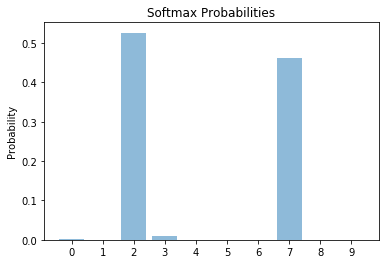

In [11]:
graphProbabilities(predictionsBlend[6])